In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Loading data

In [2]:
from sklearn.model_selection import train_test_split

def load_data(filename):
    data_df = pd.read_csv(filename)
    print("Data shape: %d x %d" % (data_df.shape))
    
    # target variable
    y = data_df['processingTime']
    
    # drop some variables
    X = data_df.drop(['protein', 'processingTime', 'resultSize'], axis=1)
    
    return (X, y)

In [3]:
X, y = load_data('whole.csv')

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=0)

Data shape: 753 x 7


In [4]:
X_train.head()

,chainSize,population,generations,machineType
627,38,200,350,Cluster
35,12,100,300,Cluster
458,100,200,400,Cloud
241,36,100,400,Local
400,100,100,300,Local


In [5]:
y_train.head()

627    276.0833
35      41.5043
458    979.0801
241    173.4608
400    677.2027
Name: processingTime, dtype: float64

In [6]:
X_test.head()

,chainSize,population,generations,machineType
648,50,20,20,Local
711,150,50,90,Cluster
404,100,100,300,Cluster
79,12,200,400,Cloud
422,100,100,400,Cluster


# Data transformation

In [7]:
categorical_features = X_train.select_dtypes(include=['object']).columns
numerical_features = X_train.select_dtypes(exclude=['object']).columns

## Categorical variables to numeric

In [8]:
from sklearn.preprocessing import LabelEncoder

def categorical_to_numerical(X_train, X_test):
    label_enc = LabelEncoder()

    X_train.loc[:, 'machineType'] = label_enc.fit_transform(X_train['machineType'])
    X_test.loc[:, 'machineType'] = label_enc.transform(X_test['machineType'])

In [9]:
categorical_to_numerical(X_train, X_test)

/home/fausto/.local/lib/python2.7/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [10]:
X_train.head()

,chainSize,population,generations,machineType
627,38,200,350,1
35,12,100,300,1
458,100,200,400,0
241,36,100,400,2
400,100,100,300,2


## Transforming skewed data

In [11]:
def feature_log(X_train, X_test, all_features=False, thresh=0.75):
    if not all_features:
        skewed_features = (X_train.apply(sp.stats.skew, axis=0) > thresh)
        X_train.loc[:, skewed_features] = np.log1p( X_train.loc[:, skewed_features] )
        X_test.loc[:, skewed_features] = np.log1p( X_test.loc[:, skewed_features] )
    else:
        X_train = np.log1p(X_train)
        X_test = np.log1p(X_test)

In [12]:
X_train_log, X_test_log = X_train.copy(), X_test.copy()

feature_log(X_train_log, X_test_log, thresh=0.5)

In [13]:
X_train_log.head()

,chainSize,population,generations,machineType
627,3.663562,200,5.860786,1
35,2.564949,100,5.707110,1
458,4.615121,200,5.993961,0
241,3.610918,100,5.993961,2
400,4.615121,100,5.707110,2


## Scaling numerical variables
Scaling data to mean=0 and standard deviation=1

In [14]:
from sklearn.preprocessing import StandardScaler

def feature_scale(X_train, X_test, numerical_features):
    std_scaler = StandardScaler()

    X_train.loc[:, numerical_features] = std_scaler.fit_transform(X_train.loc[:, numerical_features])
    X_test.loc[:, numerical_features] = std_scaler.transform(X_test.loc[:, numerical_features])

In [15]:
X_train_log_scaled, X_test_log_scaled = X_train_log.copy(), X_test_log.copy()
X_train_scaled, X_test_scaled = X_train.copy(), X_test.copy()

feature_scale(X_train_log_scaled, X_test_log_scaled, numerical_features)
feature_scale(X_train_scaled, X_test_scaled, numerical_features)

In [16]:
X_train_log_scaled.head()

,chainSize,population,generations,machineType
627,-0.057895,0.319709,0.018296,1
35,-1.269644,-0.707088,-0.131537,1
458,0.991657,0.319709,0.148142,0
241,-0.115960,-0.707088,0.148142,2
400,0.991657,-0.707088,-0.131537,2


# Scoring

In [17]:
from sklearn.metrics import r2_score, mean_squared_error

def regr_scoring(regr, X_test, y_test):
    y_true, y_pred = y_test, regr.predict(X_test)
    
    # R^2 score: higher (1), better
    print("R^2 score on new data: %f" % r2_score(y_true, y_pred))
    
    # RMSE score: lesser (0), better
    print("RMSE on new data: %f" % np.sqrt(mean_squared_error(y_true, y_pred)))
    
    plt.plot(y_pred, y_true, 'o')
    plt.xlabel('Predicted value')
    plt.ylabel('Expected value')
    #plt.plot([0, 10000], [0, 10000], 'k-')
    plt.show()

# Linear models
First we will try some linear regressions, in attempt to fit a linear model to the data.

## Linear regression

In [18]:
from sklearn.linear_model import LinearRegression

def linear_regression(X_train, X_test, y_train, y_test):
    lr = LinearRegression()
    
    lr.fit(X_train, y_train)
    
    regr_scoring(lr, X_test, y_test)

===== Raw data:
R^2 score on new data: 0.478490
RMSE on new data: 932.721890


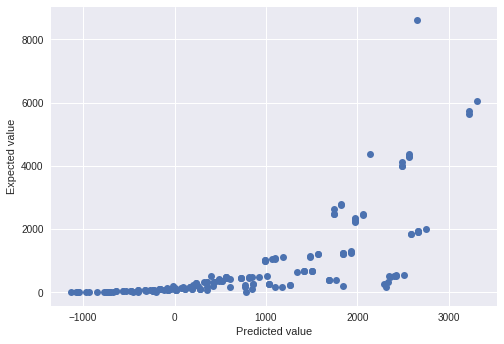

In [19]:
print('===== Raw data:')
linear_regression(X_train, X_test, y_train, y_test)

===== Scaled data:
R^2 score on new data: 0.478490
RMSE on new data: 932.721890


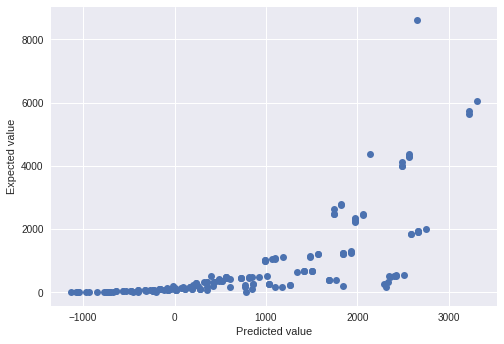

In [20]:
print('===== Scaled data:')
linear_regression(X_train_scaled, X_test_scaled, y_train, y_test)

===== Log1p data:
R^2 score on new data: 0.534667
RMSE on new data: 881.054495


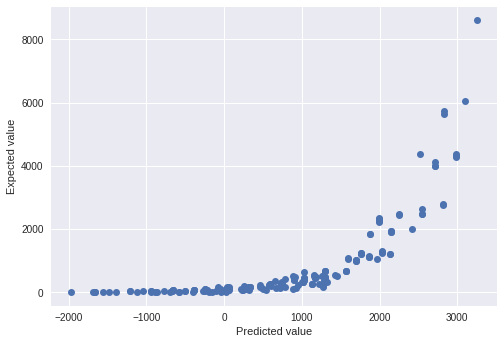

In [21]:
print('===== Log1p data:')
linear_regression(X_train_log, X_test_log, y_train, y_test)

===== Log1p scaled data:
R^2 score on new data: 0.534667
RMSE on new data: 881.054495


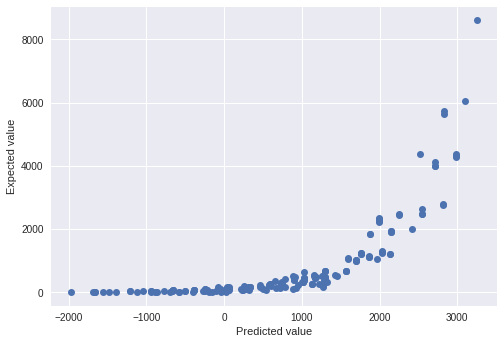

In [22]:
print('===== Log1p scaled data:')
linear_regression(X_train_log_scaled, X_test_log_scaled, y_train, y_test)

## Lasso linear model (with L1 penalty)

In [23]:
from sklearn.linear_model import LassoCV, Lasso

def lasso_fit(X_train, X_test, y_train, y_test):
    alphas = [0.000001, 0.000003, 0.000006, 0.00001, 0.00003, 0.00006, 0.0001, 0.0003, 0.0006,
              0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 0.3, 1.0, 3.0, 6.0, 10, 30, 60, 100, 300, 600]
    
    lasso_cv = LassoCV(alphas=alphas)
    lasso_cv.fit(X_train, y_train)
    
    print("# Obtained alpha on 1st round: %f" % lasso_cv.alpha_)
    
    alphas = np.linspace(0.6, 3.0, num=30) * lasso_cv.alpha_
    
    lasso_cv = LassoCV(alphas=alphas)
    lasso_cv.fit(X_train, y_train)
    
    print("# Obtained alpha on 2nd round: %f" % lasso_cv.alpha_)
    
    lasso = Lasso(alpha=lasso_cv.alpha_)
    lasso.fit(X_train, y_train)
    
    regr_scoring(lasso, X_test, y_test)

# Obtained alpha on 1st round: 300.000000
# Obtained alpha on 2nd round: 353.793103
R^2 score on new data: 0.480703
RMSE on new data: 930.741469


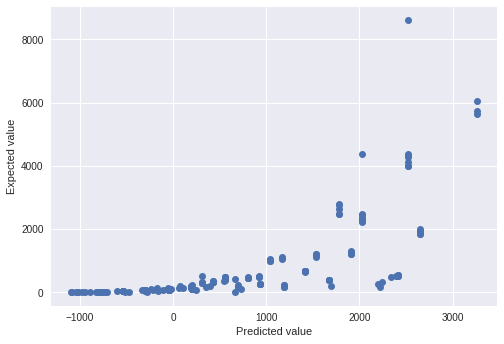

In [24]:
lasso_fit(X_train, X_test, y_train, y_test)

# Obtained alpha on 1st round: 30.000000
# Obtained alpha on 2nd round: 40.344828
R^2 score on new data: 0.492164
RMSE on new data: 920.413052


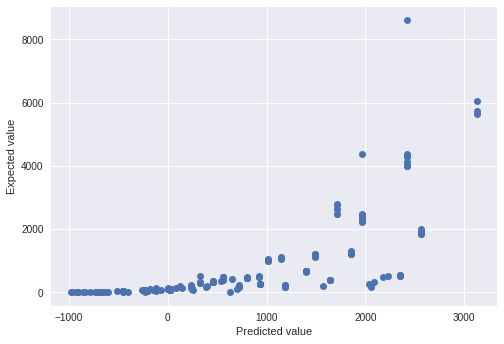

In [25]:
lasso_fit(X_train_scaled, X_test_scaled, y_train, y_test)

# Obtained alpha on 1st round: 0.100000
# Obtained alpha on 2nd round: 0.208966
R^2 score on new data: 0.534818
RMSE on new data: 880.912078


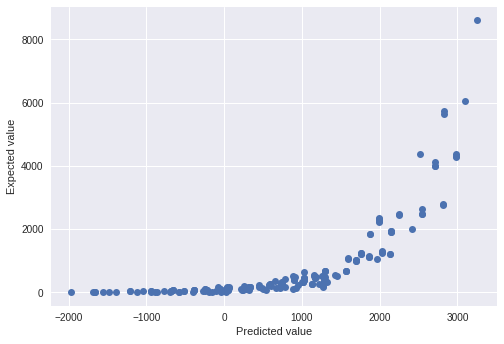

In [26]:
lasso_fit(X_train_log, X_test_log, y_train, y_test)

# Obtained alpha on 1st round: 1.000000
# Obtained alpha on 2nd round: 1.344828
R^2 score on new data: 0.535445
RMSE on new data: 880.317823


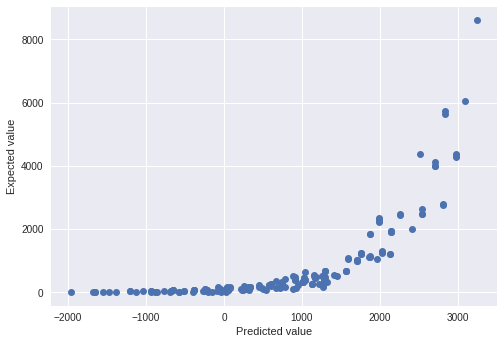

In [27]:
lasso_fit(X_train_log_scaled, X_test_log_scaled, y_train, y_test)

## Ridge regression (with L2 penalty)

In [28]:
from sklearn.linear_model import RidgeCV, Ridge

def ridge_fit(X_train, X_test, y_train, y_test):
    alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 0.3,
              1.0, 3.0, 6.0, 10, 30, 60, 100, 300, 600]
    
    ridge_cv = RidgeCV(alphas=alphas)
    ridge_cv.fit(X_train, y_train)
    
    print("# Obtained alpha on 1st round: %f" % ridge_cv.alpha_)
    
    alphas = np.linspace(0.6, 3.0, num=30) * ridge_cv.alpha_
    
    ridge_cv = RidgeCV(alphas=alphas)
    ridge_cv.fit(X_train, y_train)
    
    print("# Obtained alpha on 2nd round: %f" % ridge_cv.alpha_)
    
    ridge = Ridge(alpha=ridge_cv.alpha_)
    ridge.fit(X_train, y_train)
    
    regr_scoring(ridge, X_test, y_test)

# Obtained alpha on 1st round: 600.000000
# Obtained alpha on 2nd round: 1800.000000
R^2 score on new data: 0.479821
RMSE on new data: 931.531226


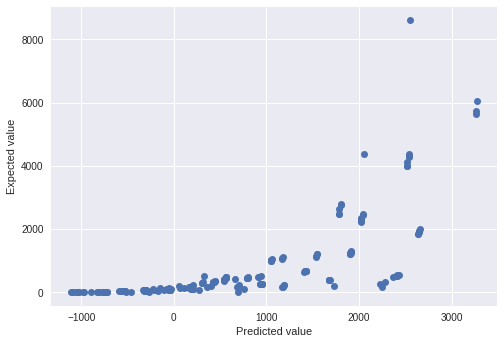

In [29]:
ridge_fit(X_train, X_test, y_train, y_test)

# Obtained alpha on 1st round: 10.000000
# Obtained alpha on 2nd round: 16.758621
R^2 score on new data: 0.487374
RMSE on new data: 924.743987


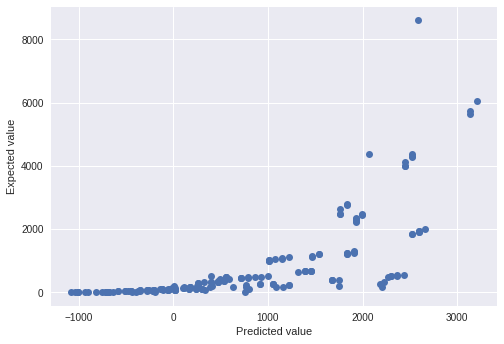

In [30]:
ridge_fit(X_train_scaled, X_test_scaled, y_train, y_test)

# Obtained alpha on 1st round: 10.000000
# Obtained alpha on 2nd round: 8.482759
R^2 score on new data: 0.540378
RMSE on new data: 875.631975


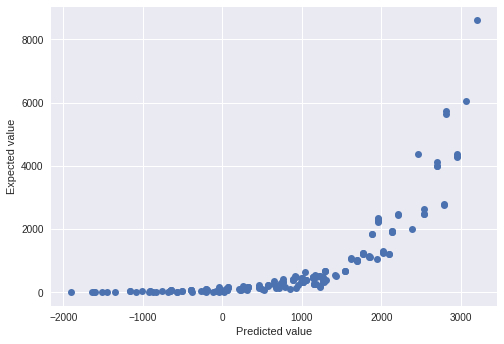

In [31]:
ridge_fit(X_train_log, X_test_log, y_train, y_test)

# Obtained alpha on 1st round: 10.000000
# Obtained alpha on 2nd round: 12.620690
R^2 score on new data: 0.540576
RMSE on new data: 875.442741


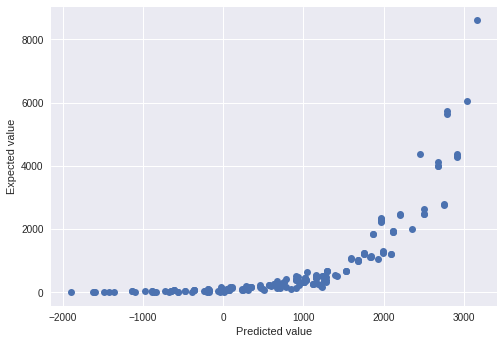

In [32]:
ridge_fit(X_train_log_scaled, X_test_log_scaled, y_train, y_test)

## Partial results
Linear models obtained unsatisfatory results. So, we will try some nonlinear models.

# SVM
As linear models obtained 

In [33]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

def svm_fit(X_train, X_test, y_train, y_test):
    svm = SVR(kernel='rbf')
    
    params = { 'C': [1, 10, 1e2, 1e3, 1e4, 1e5, 1e6] }

    gsearch = GridSearchCV(svm, param_grid=params, cv=4, verbose=0, n_jobs=2)
    gsearch.fit(X_train, y_train)
    
    print("Best parameters set found on development set:")
    print(gsearch.best_params_)
    
    print("Grid scores on development set:")
    means = gsearch.cv_results_['mean_test_score']
    stds = gsearch.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, gsearch.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
        
    regr_scoring(gsearch, X_test, y_test)

Best parameters set found on development set:
{'C': 1000000.0}
Grid scores on development set:
-0.129 (+/-0.062) for {'C': 1}
-0.075 (+/-0.042) for {'C': 10}
0.239 (+/-0.176) for {'C': 100.0}
0.757 (+/-0.307) for {'C': 1000.0}
0.817 (+/-0.202) for {'C': 10000.0}
0.921 (+/-0.124) for {'C': 100000.0}
0.921 (+/-0.124) for {'C': 1000000.0}
R^2 score on new data: 0.981717
RMSE on new data: 174.638561


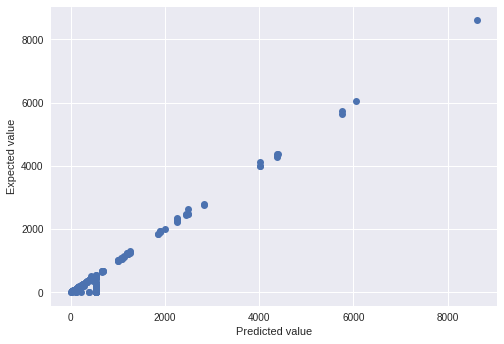

In [34]:
svm_fit(X_train, X_test, y_train, y_test)

Best parameters set found on development set:
{'C': 1000000.0}
Grid scores on development set:
-0.109 (+/-0.053) for {'C': 1}
0.078 (+/-0.103) for {'C': 10}
0.511 (+/-0.310) for {'C': 100.0}
0.797 (+/-0.309) for {'C': 1000.0}
0.865 (+/-0.235) for {'C': 10000.0}
0.945 (+/-0.059) for {'C': 100000.0}
0.959 (+/-0.065) for {'C': 1000000.0}
R^2 score on new data: 0.997020
RMSE on new data: 70.505679


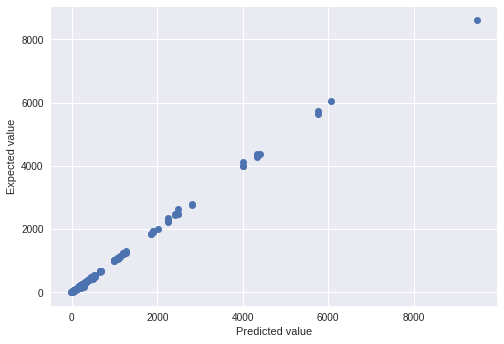

In [35]:
svm_fit(X_train_scaled, X_test_scaled, y_train, y_test)

Best parameters set found on development set:
{'C': 1000000.0}
Grid scores on development set:
-0.115 (+/-0.055) for {'C': 1}
0.059 (+/-0.100) for {'C': 10}
0.527 (+/-0.303) for {'C': 100.0}
0.740 (+/-0.331) for {'C': 1000.0}
0.864 (+/-0.204) for {'C': 10000.0}
0.908 (+/-0.096) for {'C': 100000.0}
0.949 (+/-0.032) for {'C': 1000000.0}
R^2 score on new data: 0.941480
RMSE on new data: 312.445727


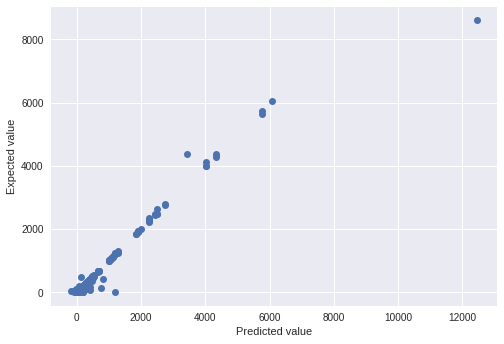

In [36]:
svm_fit(X_train_log, X_test_log, y_train, y_test)

Best parameters set found on development set:
{'C': 1000000.0}
Grid scores on development set:
-0.098 (+/-0.046) for {'C': 1}
0.142 (+/-0.142) for {'C': 10}
0.511 (+/-0.300) for {'C': 100.0}
0.776 (+/-0.321) for {'C': 1000.0}
0.874 (+/-0.214) for {'C': 10000.0}
0.918 (+/-0.096) for {'C': 100000.0}
0.928 (+/-0.082) for {'C': 1000000.0}
R^2 score on new data: 0.948519
RMSE on new data: 293.050720


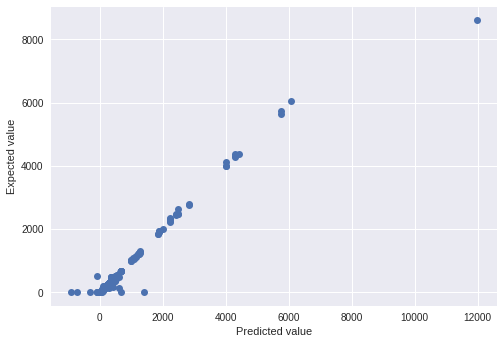

In [37]:
svm_fit(X_train_log_scaled, X_test_log_scaled, y_train, y_test)